**<h1>Vehicles Routing Problem (VRP) with Time Windows</h1>**

---



## **I. Persiapan**

### I.1 Memasang *library* (pustaka) yang diperlukan

In [ ]:
# Installing library
!pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


### I.2 Daftar modul yang diperlukan

Daftar *Library*

No.| Pustaka    | Deskripsi |
---|:-----------|:----------|
1. | Ortools    |OR-Tools adalah sebuah perpustakaan perangkat<br>lunak open-source yang dikembangkan oleh Google.<br>Ini menyediakan berbagai algoritma dan alat untuk<br>pemecahan masalah optimisasi diskrit.<br><br>OR-Tools mendukung berbagai masalah optimisasi,<br> termasuk penjadwalan, routing, pemilihan rute,<br> pemecahan masalah tata letak, pemecahan masalah produksi,<br> pemecahan masalah jadwal kru, dan banyak lagi. Ini menawarkan<br>algoritma yang efisien dan kuat untuk menyelesaikan masalah<br>ini dengan cepat dan akurat.|
2. | Matplotlib |Matplotlib adalah perpustakaan visualisasi data yang populer<br> dan kuat dalam bahasa pemrograman Python. Perpustakaan ini<br> menyediakan berbagai fungsi dan alat untuk membuat grafik,<br> plot, dan visualisasi data dengan mudah.|
3. | Numpy |

<br>

Daftar Modul

No.| Modul    | Deskripsi |
---|:-----------|:----------|
1. | ortools.constraint_solver.**routing_enums_pb2()**|Modul ini memungkinkan pengguna untuk mengakses berbagai jenis enumerasi<br> yang digunakan dalam pemecahan masalah routing dengan cara yang mudah<br> dan konsisten. Misalnya, pengguna dapat menggunakan enumerasi untuk mengatur<br>jenis algoritma pencarian yang akan digunakan (seperti algoritma TSP atau VRP)<br>atau untuk mengatur jenis strategi penjadwalan (seperti STRATEGY_BEST_INSERTION<br>atau STRATEGY_PARALLEL_CHEAPEST_INSERTION).|
2. | ortools.constraint_solver.**pywrapcp()** |Modul ini menyediakan kelas-kelas dan fungsi yang dapat digunakan untuk membuat <br> dan mengelola variabel, batasan, dan tujuan optimisasi, serta untuk menjalankan pemecahan<br> masalah constraint programming. Pengguna dapat mendefinisikan variabel dengan tipe data<br>yang sesuai, seperti integer, boolean, atau daftar, dan dapat menentukan batasan dan tujuan <br>optimisasi yang relevan dengan masalah yang ingin mereka pecahkan.|
3. | matplotlib.**pyplot()** |Bagian dari perpustakaan visualisasi data Matplotlib dalam bahasa pemrograman Python.<br>Modul ini memberikan antarmuka yang mudah digunakan untuk membuat grafik, plot, dan<br>visualisasi data.|

In [ ]:
# Importing module

# Ortools from google
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Matplotlib
import matplotlib.pyplot as plt

# Numpy
import numpy as np

### I.3 Membuat *Solver* untuk *Vehicle Routing Problem with Time Windows*

*Solver* dibuat menggunakan konsep OOP (Object Orientation Programming) dengan cara membuat Solver menjadi sebuah objek.

In [ ]:
# Membuat object Solver
# list atribut: time_matrix, time_windows, num_vehicle, max_time, dan solution
# list method: create_routing_model(), solve(), plot_route(), dan print_solution()

# Objek Solver
class VrptwSolver():

  def __init__(self, time_matrix, time_windows, num_vehicles, loc_coordinate=None, label=None):
    """Parameter
    time_matrix: Data waktu antar lokasi.
    time_windows: Data jendela waktu setiap lokasi. [(waktu_awal, waktu_akhir)]
    num_vehicles: Banyak kendaraan yang diinisiasi.
    loc_coordinate: Koordinat tiap lokasi. (opsional)
    """
    self.time_matrix = time_matrix
    self.time_windows = time_windows
    self.num_vehicles = num_vehicles
    self.loc_coordinate = loc_coordinate
    self.label = label
    self.depot = 0 # Indeks depot
    self.solution = None # Variabel untuk menyimpan solusi yang sudah tergenerate.
    self.solution_dict = {} # Variabel untuk menyimpan solusi yang sudah tergenerate dalam bentuk dictionary
    self.routing = None # Variabel untuk menyimpan model routing.
    self.manager = None # Variabel untuk menyimpan manager routing.


  def create_routing_model(self, max_time, waiting_time=0):
    """Parameter
    max_time: Batas waktu tunggu kendaraan di suatu lokasi sebelum dapat melakukan perjalanan.
    waiting_time: Batas waktu tunggu kendaraan di suatu lokasi sebelum dapat melakukan perjalanan. (default=0)
    """

    # Membuat Routing Indeks Manager.
    # Berfungsi untuk melakukan pemetaan antara indeks dan entitas dalam masalah rute.
    # Misalnya, dalam masalah perencanaan perjalanan, kita mungkin memiliki daftar lokasi yang harus dikunjungi.
    # Modul ini membantu kita mengatur dan mengelola indeks untuk setiap lokasi dalam daftar tersebut.
    self.manager = pywrapcp.RoutingIndexManager(len(self.time_matrix),
                                                self.num_vehicles,
                                                self.depot)

    # Membuat model perencanaan perjalanan.
    self.routing = pywrapcp.RoutingModel(self.manager)

    # Membuat rute transit dan menghubungkan fungsi transit kustom dengan model rute atau perencanaan perjalanan.
    transit_callback_index = self.routing.RegisterTransitCallback(
        lambda from_index, to_index: self.time_matrix[self.manager.IndexToNode(from_index)][self.manager.IndexToNode(to_index)])

    # Perhitungan biaya perjalanan (dalam waktu).
    self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Menambahkan batas waktu kendaraan pada model.
    time = 'Time' # Label
    self.routing.AddDimension(
        transit_callback_index, # Rute Transit
        waiting_time,  # Batas waktu tunggu kendaraan di suatu lokasi sebelum dapat melakukan perjalanan.
        max_time,  # Batasan waktu maksimum yang diizinkan pada setiap kendaraan untuk menyelesaikan seluruh rute kendaraan.
        False,  # waktu awal dimulai dari nol (True: ya, False: Tidak)
        time)
    time_dimension = self.routing.GetDimensionOrDie(time)

    # Menambahkan batasan jendela waktu setiap lokasi kecuali depot pada model
    for location_idx, time_window in enumerate(self.time_windows):
        if location_idx == self.depot: # Jika indeks = indeks depot maka program dilanjutkan
            continue
        index = self.manager.NodeToIndex(location_idx) # Melakukan mapping indeks
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1]) # Memastikan bahwa waktu kumulatif perjalanan tidak melebihi jendela waktu yang ditentukan

    # Menambahkan batasan jendela waktu untuk setiap simpul start kendaraan.
    depot_idx = self.depot
    for vehicle_id in range(self.num_vehicles):
        index = self.routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            self.time_windows[depot_idx][0],
            self.time_windows[depot_idx][1])

    # Instansiasi waktu mulai dan akhir rute untuk menghasilkan waktu yang layak
    for i in range(self.num_vehicles):
        self.routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(self.routing.Start(i)))
        self.routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(self.routing.End(i)))


  def print_solution(self):
    """Print Solution"""
    print(f'Objective: {self.solution.ObjectiveValue()}')
    print("")
    time_dimension = self.routing.GetDimensionOrDie('Time') # Mengambil data waktu
    total_time = 0 # Total waktu perjalanan awal

    # Mengambil data rute tiap kendaraan
    for vehicle_id in range(self.num_vehicles):
      index = self.routing.Start(vehicle_id)
      plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
      route = [] # Daftar rute setiap kendaraan
      while not self.routing.IsEnd(index):
        route.append(self.manager.IndexToNode(index)) # Mengambil indeks lokasi
        time_var = time_dimension.CumulVar(index)
        # Mengambil nilai waktu awal dan waktu akhir
        plan_output += '{0} Time({1},{2}) -> '.format(
            self.label_map(self.manager.IndexToNode(index)),
            self.solution.Min(time_var),
            self.solution.Max(time_var))
        index = self.solution.Value(self.routing.NextVar(index))

      self.solution_dict[vehicle_id] = route
      time_var = time_dimension.CumulVar(index)
      plan_output += '{0} Time({1},{2})\n'.format(self.label_map(self.manager.IndexToNode(index)),
                                                  self.solution.Min(time_var),
                                                  self.solution.Max(time_var))
      plan_output += 'Time of the route: {}min\n'.format(self.solution.Min(time_var))
      print(plan_output)
      total_time += self.solution.Min(time_var)


    print('Total time of all routes: {}min'.format(total_time))


  def plot_route(self, arrow_size=0.1):
    # Membuat visualisasi
    X = np.array([x[0] for x in self.loc_coordinate])
    Y = np.array([x[1] for x in self.loc_coordinate])

    plt.figure(figsize=(8, 6))

    plt.plot(X, Y, 'ko')
    plt.plot(X[0], Y[0], 'bX', markersize=10)

    for i, txt in enumerate(self.loc_coordinate):
      plt.text(X[i] + 0.03, Y[i] + 0.03, f"{self.label_map(i)}")

    vehicle_colors = ["g","r", "m", "c","y"]
    for vehicle in self.solution_dict:
      X_veh = X[self.solution_dict[vehicle]]
      Y_veh = Y[self.solution_dict[vehicle]]

      if len(X_veh) > 1:
        plt.plot(X_veh, Y_veh, f'{vehicle_colors[vehicle]}', label=f'vehicle - {vehicle}')
        for i in range(len(X_veh)-1):
          plt.arrow(X_veh[i], Y_veh[i], X_veh[i+1]-X_veh[i], Y_veh[i+1]-Y_veh[i], length_includes_head=True,
                    head_width=arrow_size, head_length=arrow_size, color=vehicle_colors[vehicle])

        plt.arrow(X_veh[-1], Y_veh[-1], X_veh[0]-X_veh[-1], Y_veh[0]-Y_veh[-1], length_includes_head=True,
                    head_width=arrow_size, head_length=arrow_size, color=vehicle_colors[vehicle])

    plt.legend()
    plt.grid(True)
    plt.title("Rute Perjalanan")
    plt.show()


  def solve(self):
    # Searching Parameter
    # DefaultRoutingSearchParameters() -> Menggunakan parameter default untuk melakukan proses pencarian
    # Strategi pencarian solusi awal = PATH_CHEAPEST_ARC -> Memilih busur dengan biaya paling murah dan membangun rute secara berurutan berdasarkan busur-busur tersebut.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Proses pencarian solusi optimal
    self.solution = self.routing.SolveWithParameters(search_parameters)

    # Tampilkan solusi jika solusi ditemukan
    if self.solution:
      self.print_solution()
    else:
      print("""
      Tidak ada solusi !

      Saran:
      Anda dapat menambahkan jendela waktu, waktu maksimum perjalanan tiap kendaraan atau
      menambah jumlah kendaraan.""")

  def label_map(self, index):
    '''Mengubah indeks menjadi label yang diinginkan'''
    return self.label[index]



### I.4 Referensi koordinat tiap titik lokasi

Titik lokasi disesuaikan dengan gambar graph yang ada di Bab4. Titik koordinat dibuat menggunakan geogebra dengan memanfaatkan gambar yang telah dibuat. Link geogera.

- A1: https://www.geogebra.org/m/b2bwgjgk
- A2: https://www.geogebra.org/m/stxdfajp
- A4: https://www.geogebra.org/m/gvver8ty
- A5: https://www.geogebra.org/m/qeufzdm2
- B1: https://www.geogebra.org/m/pxdgk7re

## **II. Contoh Penggunaan objek VrptwSolver**

### Data yang perlu disiapkan




***Time Matrix***<br>
Matrix data waktu tempuh antar lokasi. contoh:

In [ ]:
time_matrix = [
  [0, 18, 15],
  [18, 0, 3],
  [15, 3, 0],
]

***Time Windows***<br>
Data jendela waktu tiap lokasi.

In [ ]:
time_windows = [
  # (waktu kedatangan awal, waktu kedatangan akhir)
  (0, 60), # Depot
  (15, 120), # Lokasi 1
  (0, 30), # Lokasi 2
]



Jendela waktu terdiri dari dua komponen: waktu kedatangan awal (earliest arrival time) dan waktu kedatangan akhir (latest arrival time). Waktu kedatangan awal menunjukkan waktu minimum ketika kendaraan dapat tiba di pelanggan, sementara waktu kedatangan akhir menunjukkan waktu maksimum ketika kendaraan harus tiba di pelanggan.

**Penjelasan**<br>
Jika waktu didefinisikan dalam bentuk menit, maka nilai time windows diatas adalah +menit dari waktu awal perjalanan.<br>
Contoh:<br>
Lokasi 1 mempunyai jendela waktu 15 (waktu awal) hingga 120 (waktu akhir). Misal memulai rute perjalanan pada pukul 9AM, maka waktu diperbolehkannya kendaraan masuk Lokasi 1 yaitu diantara pukul 9.15 AM (9 jam + 15 menit) hingga 11 AM (9 Jam + 120 menit(2 jam)).

***Number Vehicle***<br>
Number of Vehicles (jumlah kendaraan) adalah parameter yang menentukan berapa banyak kendaraan yang tersedia untuk digunakan dalam merencanakan rute pengiriman atau distribusi. Setiap kendaraan akan diberikan tugas untuk mengunjungi pelanggan dan memenuhi jendela waktu yang ditetapkan.

In [ ]:
num_vehicles = 2

Fungsi Number of Vehicles dalam VRPTW adalah untuk memaksimalkan efisiensi operasional dengan meminimalkan biaya dan waktu pengiriman. Jika jumlah kendaraan terlalu sedikit, maka kendaraan akan terlalu padat dan tidak dapat mengunjungi semua pelanggan dalam waktu yang efisien. Sebaliknya, jika jumlah kendaraan terlalu banyak, itu bisa mengakibatkan biaya operasional yang tinggi dan penggunaan sumber daya yang tidak efisien.

Dalam merencanakan rute kendaraan dalam VRPTW, tujuan utamanya adalah mengoptimalkan penggunaan kendaraan yang tersedia dan memastikan bahwa semua pelanggan dapat dilayani dengan efisien dalam batasan waktu yang ditentukan. Oleh karena itu, pemilihan Number of Vehicles yang tepat menjadi penting dalam mencapai solusi yang baik dan optimal.

***Location Coordinate***<br>
Koordinat lokasi.


In [ ]:
loc_coor = [
  (2, 3),
  (4, 5),
  (5, 3)
]

*Label location*

Label tiap titik lokasi


In [ ]:
label = ['Depot', 1, 2, 3]

*Max time per vehicle*

Maksimal waktu per kendaraan mengacu pada batasan waktu maksimum yang diizinkan untuk satu kendaraan dalam melakukan perjalanan sebelum harus kembali ke depot.

In [ ]:
max_time_per_vehicle = 60 # 60 minutes

### Flows analisa

List method dari objek yang dibuat
- `VrptwSolver()` -> Membuat objek data model
- `VrptwSolver.create_routing_model()` -> Membuat model rute perjalanan
- `VrptwSolver.solve()` -> Optimisasi rute terbaik
- `Vrptw.plot_route()` -> Membuat visualisasi rute


In [ ]:
# 1. Membuat objek data model
vrptw = VrptwSolver(time_matrix, time_windows, num_vehicles, loc_coor, label)

# 2. Membuat model rute perjalanan
vrptw.create_routing_model(max_time_per_vehicle)

# 3. Mencari rute optimal
vrptw.solve()

Objective: 36

Route for vehicle 0:
Depot Time(0,0) -> Depot Time(0,0)
Time of the route: 0min

Route for vehicle 1:
Depot Time(0,0) -> 2 Time(15,15) -> 1 Time(18,18) -> Depot Time(36,36)
Time of the route: 36min

Total time of all routes: 36min


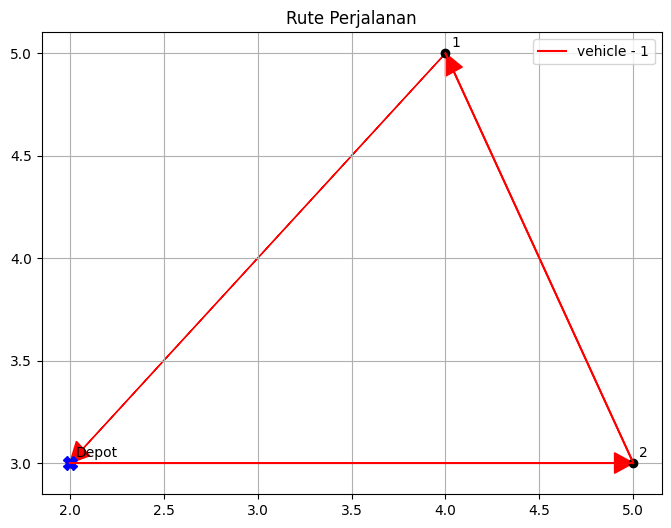

In [ ]:
# 4. Membuat visualisasi rute
vrptw.plot_route()

## **III. Pemecahan Masalah (Contoh)**

Contoh permasalahan

- Proses evakuasi akan dilaksanakan puku 8 pagi.
- Proses evakuasi akan dilaksanakan dengan batas waktu 1 jam dimulai dari keberangkatan awal (8 pagi).
- Semua titik lokasi penjemputan harus berhasil dikunjungi dalam waktu 1 jam (Semua titik penjemputan harus dikunjungi dalam rentang waktu jam 8 samapi 9 pagi) - Depot tidak dihitung.
- Batas lama perjalanan tiap kendaraa (lama waktu perjalanan dari depot - menuju depot) adalah 1 jam.

Tentukan rute optimal dan berapa kendaraan yang dibutuhkan

### III.1. Rute Tempat Evakuasi Akhir **Desa Banyu Rejo (A1)**

*Data preparation*

In [ ]:
# Time Matrix (in minutes)
time_matrix_a1 = [[0, 18, 15, 11, 10, 10, 7],
                  [18, 0, 3, 8, 11, 11, 11],
                  [15, 3, 0, 5, 8, 8, 8],
                  [11, 8, 5, 0, 5, 4, 4],
                  [10, 11, 8, 5, 0, 1, 4],
                  [10, 11, 8, 4, 1, 0, 4],
                  [7, 11, 8, 4, 4, 4, 0]]

# Time Windows
# Evacuation time -> 8 AM - 9 AM
# Evacuation time limit -> 1 hour (60 minutes)
# Evacuation time span for each location is the same

time_windows_a1 = [
    (0, 0),  # depot A1
    (0, 60),  # 20
    (0, 60),  # 21
    (0, 60),  # 22
    (0, 60),  # 23
    (0, 60),  # 24
    (0, 60),  # 25
]

num_vehicles_a1 = 1

max_time_per_vehicle_a1 = 60 # Max time

coordinate_loc_a1 = [
    (7, 8), # Depot
    (9.81,7.01), # 20
    (10.55,4.37), # 21
    (7.63,2.13), # 22
    (4.99,3.13), # 23
    (3.38,4.94), # 24
    (4.31,7.21) # 25
]

label_a1 = ['A1', 20, 21, 22, 23, 24, 25]

*Searching solution*

In [ ]:
vprtw_a1 = VrptwSolver(time_matrix_a1, time_windows_a1, num_vehicles_a1, coordinate_loc_a1, label_a1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a1.create_routing_model(max_time_per_vehicle) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a1.solve()

Objective: 41

Route for vehicle 0:
A1 Time(0,0) -> 25 Time(7,7) -> 20 Time(18,18) -> 21 Time(21,21) -> 22 Time(26,26) -> 24 Time(30,30) -> 23 Time(31,31) -> A1 Time(41,41)
Time of the route: 41min

Total time of all routes: 41min


*Visualization*

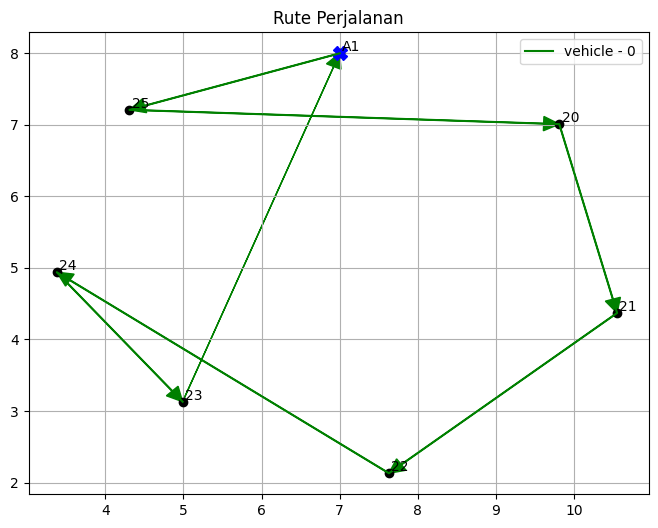

In [ ]:
vprtw_a1.plot_route(arrow_size=0.2) # arrow_size berfungsi untuk mengatur ukuran mata panah

### III.2. Rute Tempat Evakuasi Akhir **GOR Pangukan (A2)**

*Data preparation*

In [ ]:
# Time Matrix (in minutes)
time_matrix_a2 = [
    [0, 19, 23, 22, 22, 26, 18, 16, 18],
    [19, 0, 8, 4, 4, 12, 5, 14, 9],
    [23, 8, 0, 1, 1, 12, 8, 15, 11],
    [22, 4, 1, 0, 1, 11, 7, 14, 10],
    [22, 4, 1, 1, 0, 11, 7, 14, 10],
    [26, 12, 12, 11, 11, 0, 9, 12, 8],
    [18, 5, 8, 7, 7, 9, 0, 8, 4],
    [16, 14, 15, 14, 14, 12, 8, 0, 4],
    [18, 9, 11, 10, 10, 8, 4, 4, 0]
]

# Time Windows
# Evacuation time -> 8 AM - 9 AM
# Evacuation time limit -> 1 hour (60 minutes)
# Evacuation time span for each location is the same

time_windows_a2 = [
    (0, 0),  # depot A2
    (0, 60),  # 6
    (0, 60),  # 7
    (0, 60),  # 8
    (0, 60),  # 9
    (0, 60),  # 10
    (0, 60),  # 19
    (0, 60),  # 26
    (0, 60),  # 28
]

num_vehicles_a2 = 1

max_time_per_vehicle_a2 = 60

coordinate_loc_a2 = [
    (7.69,8.55), # Depot
    (9.79,7.69), # 6
    (11.57,5.87), # 7
    (11.13,3.69), # 8
    (9.57,2.03), # 9
    (7,2), # 10
    (4.65,3.01), # 19
    (4.03,5.37), # 26
    (5.03,7.43) # 28
]

label_a2 = ['A2', 6, 7, 8, 9, 10, 19, 26, 28]


Searching solution

In [ ]:
vprtw_a2 = VrptwSolver(time_matrix_a2, time_windows_a2, num_vehicles_a2, coordinate_loc_a2, label_a2) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a2.create_routing_model(max_time_per_vehicle_a2) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a2.solve()

NameError: ignored

In [ ]:
# Tidak ada solusi untuk satu kendaraan
# dapat melakukan perjalan dari depot A2 - menuju titik lokasi penjemputan - sampai kembali
# lagi ke depot A2 dalam 1 jam
# solusi menambah jumlah kendaraan

num_vehicles_a2 = 2 # menambah jumlah kendaraan

vprtw_a2 = VrptwSolver(time_matrix_a2, time_windows_a2, num_vehicles_a2, coordinate_loc_a2, label_a2) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a2.create_routing_model(max_time_per_vehicle_a2) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a2.solve()

*Visualization*

In [ ]:
vprtw_a2.plot_route(arrow_size=0.3)

### III.3. Rute Tempat Evakuasi Akhir **Stadion Maguwoharjo (A4)**

*Data preparation*

In [ ]:
# Time Matrix (in minutes)
time_matrix_a4 = [
    [0, 26, 18, 16],
    [26, 0, 7, 8],
    [18, 7, 0, 1],
    [16, 8, 1, 0]
]

# Time Windows
# Evacuation time -> 8 AM - 9 AM
# Evacuation time limit -> 1 hour (60 minutes)
# Evacuation time span for each location is the same

time_windows_a4 = [
    (0, 0),  # depot A4
    (0, 60),  # 11
    (0, 60),  # 27
    (0, 60),  # 29
]

num_vehicles_a4 = 1

max_time_per_vehicle_a4 = 60

coordinate_loc_a4 = [
    (4, 6), # Depot
    (6.24,4.03), # 11
    (4.22,1.76), # 27
    (1.93,4.14) # 29

]

label_a4 = ['A4', 11, 27, 29]

*Searching solution*

In [ ]:
vprtw_a4 = VrptwSolver(time_matrix_a4, time_windows_a4, num_vehicles_a4, coordinate_loc_a4, label_a4) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a4.create_routing_model(max_time_per_vehicle_a4) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a4.solve()

Objective: 49

Route for vehicle 0:
A4 Time(0,0) -> 29 Time(16,16) -> 11 Time(24,24) -> 27 Time(31,31) -> A4 Time(49,49)
Time of the route: 49min

Total time of all routes: 49min


*Visualization*

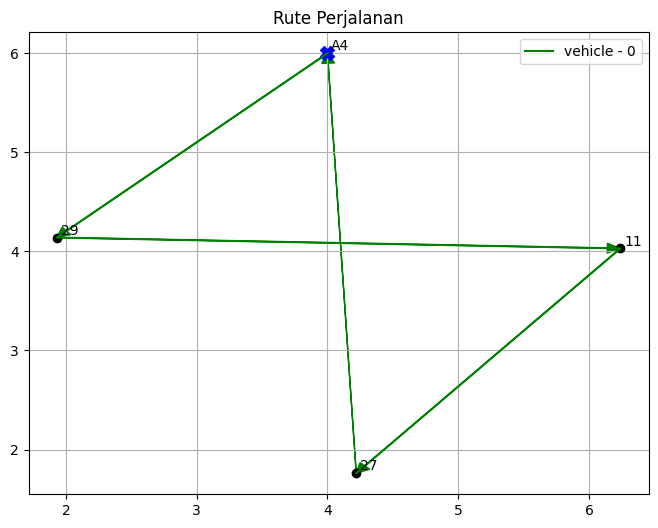

In [ ]:
vprtw_a4.plot_route(arrow_size=0.1)

### III.4. Rute Tempat Evakuasi Akhir **Barak Pengungsian Tirtomartani (A5)**

In [ ]:
# Time Matrix (in minutes)
time_matrix_a5 = [
    [0,23,21,26,22,22,23,26,15,14,9,14,10],
    [23,0,2,7,11,12,5,5,5,16,7,19,16],
    [21,2,0,8,9,10,4,4,7,15,5,17,15],
    [26,7,8,0,9,10,9,10,5,18,12,19,18],
    [22,11,9,9,0,5,10,10,13,10,10,11,13],
    [22,12,10,10,5,0,9,12,16,7,8,8,11],
    [23,5,4,9,10,9,0,6,6,13,9,16,9],
    [26,5,4,10,10,12,6,0,12,18,15,20,15],
    [15,5,7,5,13,16,6,12,0,20,5,22,4],
    [14,16,15,18,10,7,13,18,20,0,12,5,5],
    [9,7,5,12,10,8,9,15,5,12,0,14,1],
    [14,19,17,19,11,8,16,20,22,5,14,0,6],
    [10,16,15,18,13,11,9,15,4,5,1,6,0],
]

# Time Windows
# Evacuation time -> 8 AM - 9 AM
# Evacuation time limit -> 1 hour (60 minutes)
# Evacuation time span for each location is the same

time_windows_a5 = [
    (0, 0),  # A5
    (0, 60),  # 12
    (0, 60),  # 13
    (0, 60),  # 14
    (0, 60),  # 15
    (0, 60),  # 16
    (0, 60),  # 17
    (0, 60),  # 18
    (0, 60),  # 30
    (0, 60),  # 31
    (0, 60),  # 32
    (0, 60),  # 33
    (0, 60),  # 34
]

num_vehicles_a5 = 1

max_time_per_vehicle_a5 = 60

coordinate_loc_a5 = [
    (8.75,11.97), # Depot A5
    (11.33,10.83), # 12
    (13,9.1), # 13
    (14.07,7.15), # 14
    (14,4.1), # 15
    (12.61,2.03), # 16
    (9.47,1.17), # 17
    (5.97,1.63), # 18
    (3.81,3.23), # 30
    (2.49,5.21), # 31
    (2.9,8), # 32
    (3.97,10.19), # 33
    (5.99,11.37) # 34
]

label_a5 = ['A4', 12, 13, 14, 15, 16, 17, 18, 30, 31, 32, 33, 34]

In [ ]:
vprtw_a5 = VrptwSolver(time_matrix_a5, time_windows_a5, num_vehicles_a5, coordinate_loc_a5, label_a5) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a5.create_routing_model(max_time_per_vehicle_a5) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a5.solve()


      Tidak ada solusi !

      Saran:
      Anda dapat menambahkan jendela waktu, waktu maksimum perjalanan tiap kendaraan atau
      menambah jumlah kendaraan.


In [ ]:
# Tidak ada solusi untuk satu kendaraan
# dapat melakukan perjalan dari depot A5 - menuju titik lokasi penjemputan - sampai kembali
# lagi ke depot A5 dalam 1 jam
# solusi menambah jumlah kendaraan

num_vehicles_a5 = 2 # menambah jumlah kendaraan

vprtw_a5 = VrptwSolver(time_matrix_a5, time_windows_a5, num_vehicles_a5, coordinate_loc_a5, label_a5) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a5.create_routing_model(max_time_per_vehicle_a5) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a5.solve()

Objective: 106

Route for vehicle 0:
A4 Time(0,0) -> 32 Time(9,9) -> 13 Time(14,14) -> 12 Time(16,16) -> 18 Time(21,21) -> 17 Time(27,27) -> 34 Time(36,36) -> A4 Time(46,46)
Time of the route: 46min

Route for vehicle 1:
A4 Time(0,0) -> 30 Time(15,15) -> 14 Time(20,20) -> 15 Time(29,29) -> 16 Time(34,34) -> 31 Time(41,41) -> 33 Time(46,46) -> A4 Time(60,60)
Time of the route: 60min

Total time of all routes: 106min


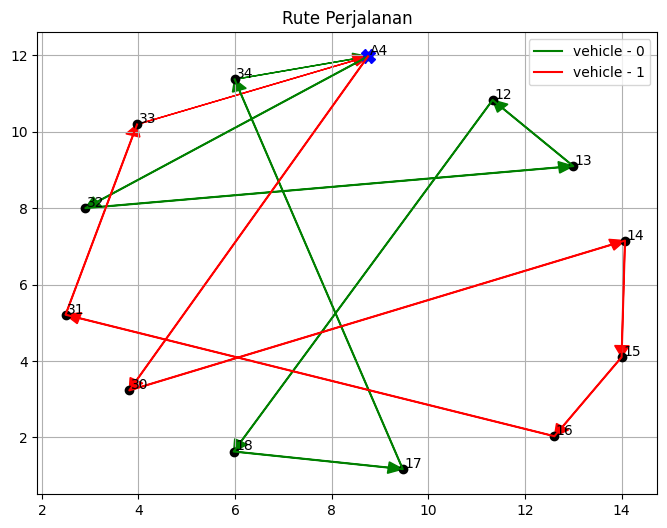

In [ ]:
vprtw_a5.plot_route(arrow_size=0.3)

### III.5. Rute Tempat Evakuasi Akhir Ternak **Pasar Agropolitas Purwobinangun (B1)**

In [ ]:
# Time Matrix (in minutes)
time_matrix_b1 = [
    [0, 36, 31, 30, 18, 22],
    [36, 0, 20, 20, 29, 29],
    [31, 20, 0, 4, 12, 22],
    [30, 20, 4, 0, 17, 14],
    [18, 29, 12, 17, 0, 6],
    [22, 29, 22, 14, 6, 0]
]

# Time Windows
# Evacuation time -> 8 AM - 10 AM
# Evacuation time limit -> 1 hour (60 minutes)
# Evacuation time span for each location is the same

time_windows_b1 = [
    (0, 0),  # depot B1
    (0, 60),  # A
    (0, 60),  # B
    (0, 60),  # C
    (0, 60),  # D
    (0, 60),  # E
]

num_vehicles_b1 = 1

max_time_per_vehicle_b1 = 60

coordinate_loc_b1 = [
    (4.88,6.51), # Depot B1
    (7.38,5.17), # A
    (7.84,2.39), # B
    (4.86,1.11), # C
    (1.84,2.39), # D
    (2.32,5.13) # E
]

label_b1 = ['B1', 'A', 'B', 'C', 'D', 'E']

In [ ]:
vprtw_b1 = VrptwSolver(time_matrix_b1, time_windows_b1, num_vehicles_b1, coordinate_loc_b1, label_b1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_b1.create_routing_model(max_time_per_vehicle_b1) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_b1.solve()


      Tidak ada solusi !

      Saran:
      Anda dapat menambahkan jendela waktu, waktu maksimum perjalanan tiap kendaraan atau
      menambah jumlah kendaraan.


In [ ]:
# Tidak ada solusi untuk satu kendaraan
# dapat melakukan perjalan dari depot A5 - menuju titik lokasi penjemputan - sampai kembali
# lagi ke depot A5 dalam 1 jam
# solusi menambah jumlah kendaraan

num_vehicles_b1 = 2 # menambah jumlah kendaraan

vprtw_b1 = VrptwSolver(time_matrix_b1, time_windows_b1, num_vehicles_b1, coordinate_loc_b1, label_b1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_b1.create_routing_model(max_time_per_vehicle_b1) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_b1.solve()


      Tidak ada solusi !

      Saran:
      Anda dapat menambahkan jendela waktu, waktu maksimum perjalanan tiap kendaraan atau
      menambah jumlah kendaraan.


In [ ]:
# Tidak ada solusi untuk dua kendaraan
# dapat melakukan perjalan dari depot B1 - menuju titik lokasi penjemputan - sampai kembali
# lagi ke depot B1 dalam 1 jam
# solusi menambah batas waktu maksimal karena jarak depot ke titik terjauh (A) membutuhkan
# waktu lebih dari 60 menit atau 1 jam (bolak-balik)

max_time_per_vehicle_b1 = 90 # menambah maksimal waktu perjalanan menjadi 90 menit
num_vehicles_b1 = 2

vprtw_b1 = VrptwSolver(time_matrix_b1, time_windows_b1, num_vehicles_b1, coordinate_loc_b1, label_b1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_b1.create_routing_model(max_time_per_vehicle_b1) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_b1.solve()

Objective: 136

Route for vehicle 0:
B1 Time(0,0) -> C Time(30,30) -> B Time(34,34) -> A Time(54,54) -> B1 Time(90,90)
Time of the route: 90min

Route for vehicle 1:
B1 Time(0,0) -> E Time(22,22) -> D Time(28,28) -> B1 Time(46,46)
Time of the route: 46min

Total time of all routes: 136min


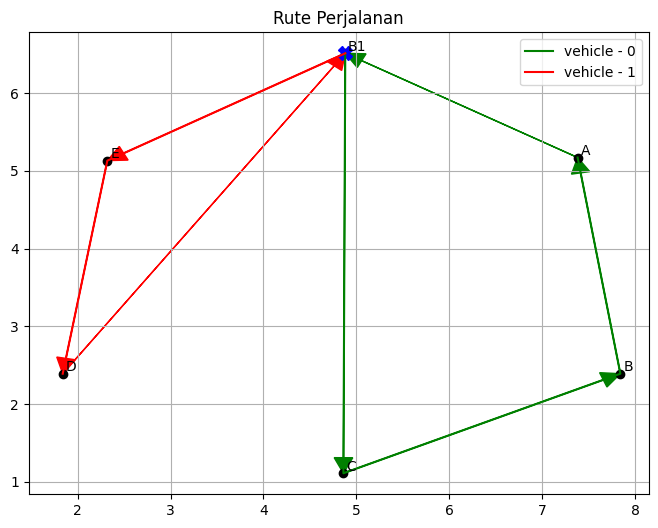

In [ ]:
vprtw_b1.plot_route(arrow_size=0.2)

## **IV. Pemecahan Masalah**

### IV.1. Rute Tempat Evakuasi Akhir **Desa Banyu Rejo (A1)**

#### 30 Menit

In [ ]:
# Dataset

# Time
time = 30
# Time Matrix (in minutes)
time_matrix_a1 = [[0, 18, 15, 11, 10, 10, 7],
                  [18, 0, 3, 8, 11, 11, 11],
                  [15, 3, 0, 5, 8, 8, 8],
                  [11, 8, 5, 0, 5, 4, 4],
                  [10, 11, 8, 5, 0, 1, 4],
                  [10, 11, 8, 4, 1, 0, 4],
                  [7, 11, 8, 4, 4, 4, 0]]
# Time windows
time_windows_a1 = [
    (0, time),  # depot A1
    (0, time),  # 20
    (0, time),  # 21
    (0, time),  # 22
    (0, time),  # 23
    (0, time),  # 24
    (0, time),  # 25
]
# Coordinate
coordinate_loc_a1 = [
    (7, 8), # Depot
    (9.81,7.01), # 20
    (10.55,4.37), # 21
    (7.63,2.13), # 22
    (4.99,3.13), # 23
    (3.38,4.94), # 24
    (4.31,7.21) # 25
]


In [ ]:
# Searching Solution

# First iteration:
# 1. Num Vehicle -> 1
# 2. Max time windows -> 30
# 3. Max time per vehicle -> 30

# Number Vehicle
num_vehicles_a1 = 1

# Maximum time per vehicle
max_time_per_vehicle_a1 = 30

# Label
label_a1 = ['A1', 20, 21, 22, 23, 24, 25]

vprtw_a1 = VrptwSolver(time_matrix_a1, time_windows_a1, num_vehicles_a1, coordinate_loc_a1, label_a1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a1.create_routing_model(max_time_per_vehicle_a1) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a1.solve()


      Tidak ada solusi !

      Saran:
      Anda dapat menambahkan jendela waktu, waktu maksimum perjalanan tiap kendaraan atau
      menambah jumlah kendaraan.


In [ ]:
# Searching Solution

# Second iteration:
# 1. Num Vehicle -> 1
# 2. Max time windows -> 30
# 3. Max time per vehicle -> 45

# Number Vehicle
num_vehicles_a1 = 1

# Maximum time per vehicle
max_time_per_vehicle_a1 = 45

# Label
label_a1 = ['A1', 20, 21, 22, 23, 24, 25]

vprtw_a1 = VrptwSolver(time_matrix_a1, time_windows_a1, num_vehicles_a1, coordinate_loc_a1, label_a1) # Membuat objek solver dengan data yang telah ditentukan
vprtw_a1.create_routing_model(max_time_per_vehicle_a1) # Membuat model perjalanan dengan batas waktu maksimal penyelesaian tiap kendaraan
vprtw_a1.solve()

Objective: 42

Route for vehicle 0:
A1 Time(0,0) -> 25 Time(7,7) -> 23 Time(11,11) -> 24 Time(12,12) -> 22 Time(16,16) -> 21 Time(21,21) -> 20 Time(24,24) -> A1 Time(42,42)
Time of the route: 42min

Total time of all routes: 42min


Keterangan:
- Waktu tercepat dengan solusi yang paling optimal dari proses evakuasi (jika dihitung dari depot sampai kembali ke depot) adalah **42 menit**. Tidak ditemukan solusi jika waktu evakuasi ditetapkan **30 menit**.<br>
Mengapa tidak ada solusi? Ini disebabkan karena waktu tempuh dari depot ke suatu titik tertentu dan kembali lagi ke dpot dibutuhkan waktu lebih dari 30 menit. <br>
Misal pada data waktu tempuh antara depot ke titik 20 adalah **18 menit**. Artinya kendaraan saat melakukan evakuasi membutuhkan waktu paling cepat **36 menit**. depot -> titik 20 (18 menit) dan titik 20 -> depot (18 menit)